# Machine Learning - Assignment 1

<p>Ana Raquel Maceiras - up200604342<br>
<\br>Hélder Miguel Carvalho Vieira - up201503395<br>
<\br>Miguel Tavares - up200902937<br>
<\br>Rui Pedro Oliveira do Amaral Vieira - up201403035<\p>

## Introduction

Classification problems...

For artificial data sets, as the original distributions from which the data was generated are known, the exact Bayes Decision Boundary can be calculated and visualized. However, in real life classification problems, the Bayes Decision Boundary is not known. Thus, Machine Learning algorithms try to find the closest Decision Boundary to the Bayes Decision Boundary that in turn allows to divide 

up the feature space such that labels are assigned correctly to points in the feature space, or at least, as correctly as is possible . 
The Decision Boundary separates the data-points into regions, which are actually the classes in which they belong.
 
Different methods produce models with different degrees of expressivity (the
variety of functions emulated) and some methods have hyperparameters that increase or reduce the expressivity
of the models. More expressive models often incur in overfitting, which is related to the bias-variance trade-off.
The aim of this first assignment is to perform a short study on the behavior of methods with respect to their
ability of approximating the Bayes Decision Boundary and where they stand in the bias-variance tradeoff.

Total error | Bias-Variance trade off | Overfitting | model complexity

In [1]:
#Import of the necessary libraries 
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, validation_curve
from sklearn.neighbors import KNeighborsClassifier as kNN
from sklearn.linear_model import LogisticRegression as LogReg
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.tree import DecisionTreeClassifier as DTreeClass
from sklearn.metrics import accuracy_score, zero_one_loss, roc_auc_score, roc_curve, classification_report, f1_score

## Section 1 - How can we find an approximate decision boundary?

As referred before, Machine Learning algorithms try to approximate the true Decision Boundary. The goodness of such boundary will depend on the error associated with each model prediction which in turn 

In [2]:
diabetes = pd.read_csv("diabetes.csv")
#diabetes

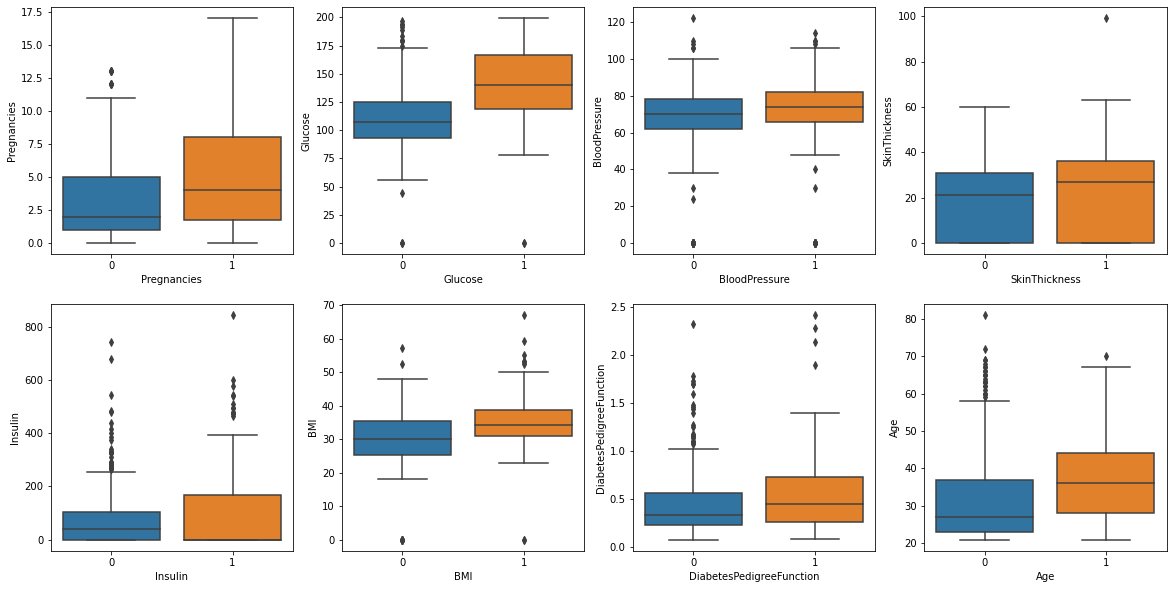

In [3]:
cols = diabetes.columns[:8]
fig, ax = plt.subplots(2,4, sharex=False, sharey=False, figsize=(20, 10))
for i in range(len(cols)):
    sns.boxplot(ax=ax[i//4, i%4], y=cols[i], x='Outcome', data=diabetes)
    ax[i//4, i%4].set(xlabel=cols[i])
plt.show()

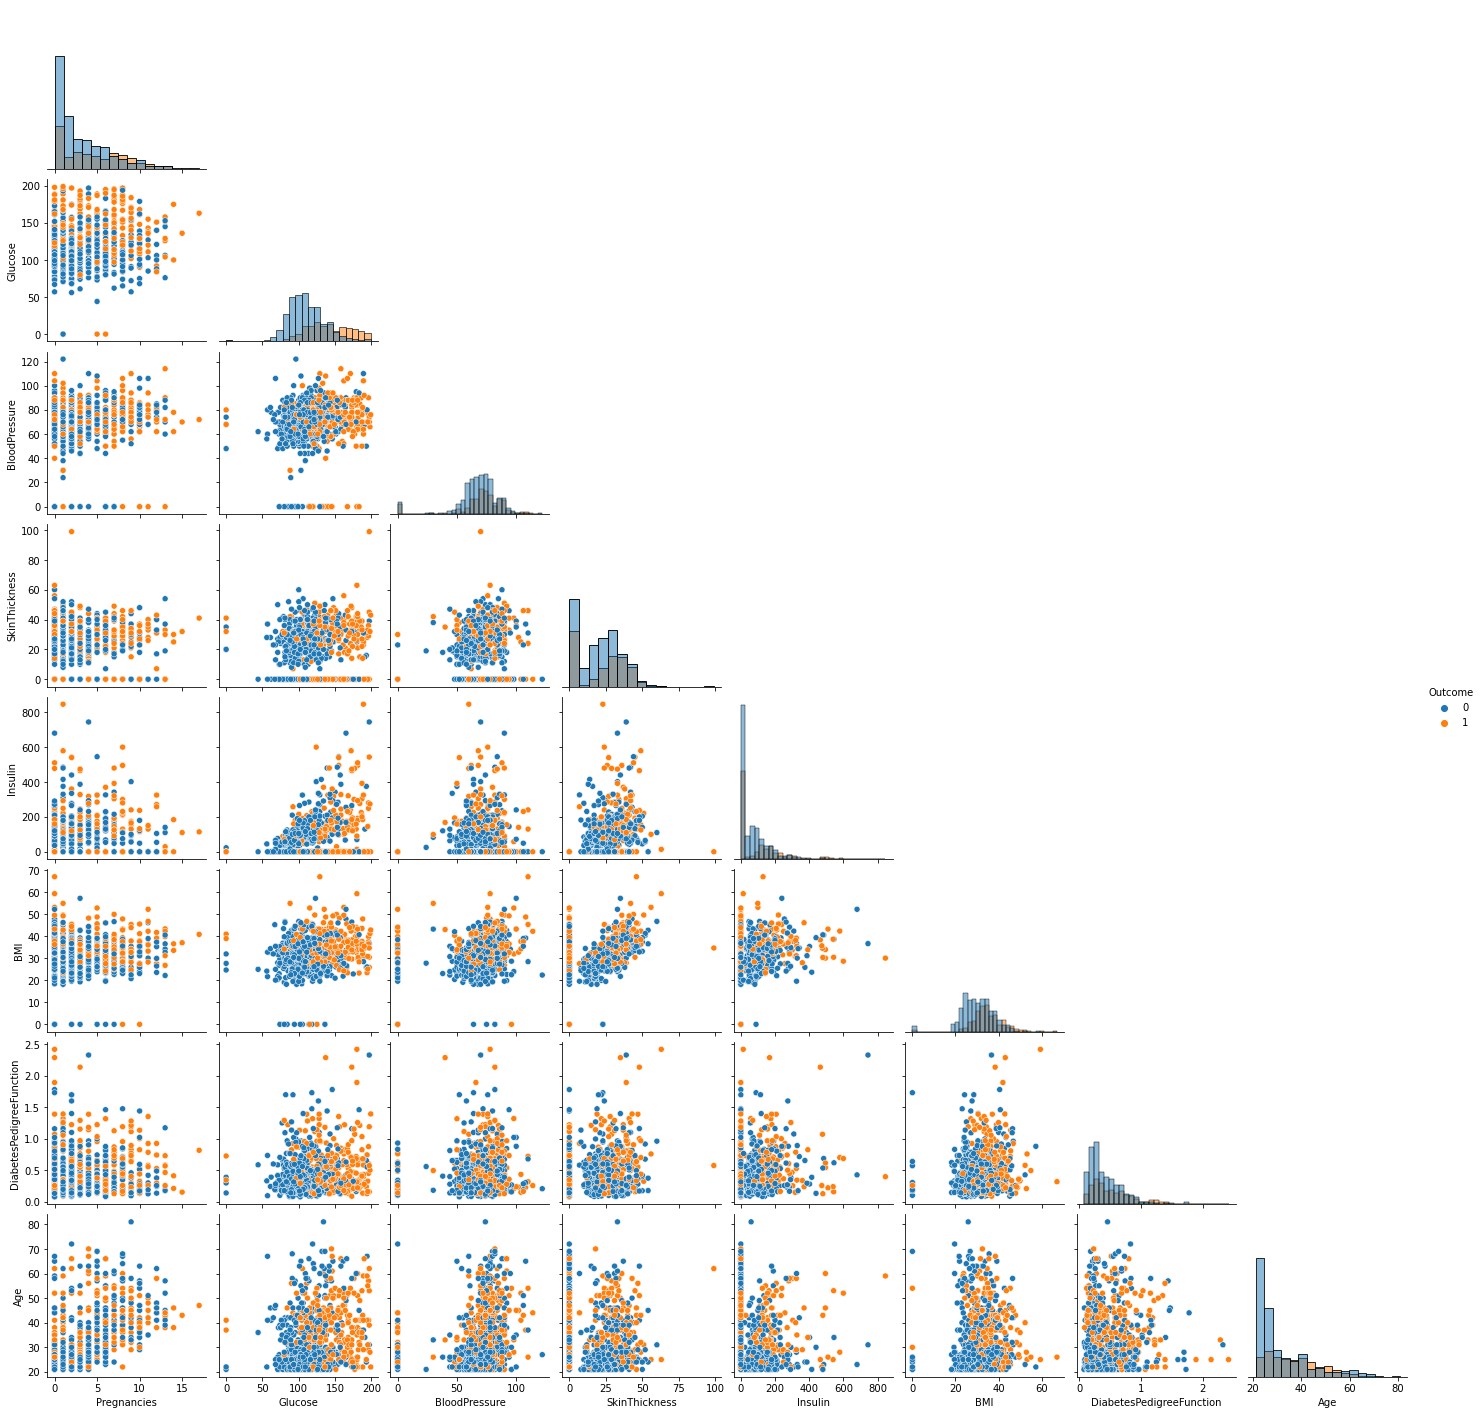

In [4]:
sns.pairplot(diabetes, hue='Outcome', diag_kind="hist", corner=True);

In [5]:
for i in diabetes.columns[1:8]:
    print(i,  len(diabetes.loc[(diabetes[i]==0),i]))

Glucose 5
BloodPressure 35
SkinThickness 227
Insulin 374
BMI 11
DiabetesPedigreeFunction 0
Age 0


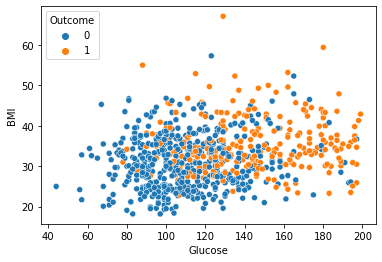

In [6]:
diabetes.loc[(diabetes['Glucose']==0),'Glucose']=np.nan
diabetes.loc[(diabetes['BMI']==0),'BMI']=np.nan
diabetes.dropna(inplace=True)
sns.scatterplot(data=diabetes, x="Glucose", y="BMI", hue="Outcome");

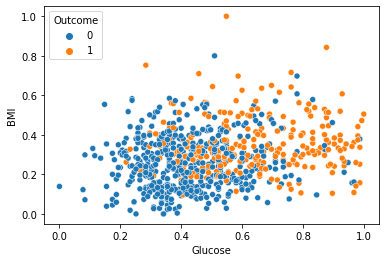

In [7]:
MinMaxSca = MinMaxScaler()
diabetes[['Glucose','BMI']] = MinMaxSca.fit_transform(diabetes.loc[:,['Glucose','BMI']])
sns.scatterplot(data=diabetes, x="Glucose", y="BMI", hue="Outcome");

In [8]:
x = diabetes.loc[:, ['Glucose', 'BMI']].values
y = diabetes.loc[:,'Outcome'].values

In [9]:
def plot_classifier_boundary(model,X,h = .05): #kindly provided in class
    cmap_light = colors.ListedColormap(['lightsteelblue', 'peachpuff'])
    x_min, x_max = x[:, 0].min()-.2, x[:, 0].max()+.2
    y_min, y_max = x[:, 1].min()-.2, x[:, 1].max()+.2
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=cmap_light)
    plt.xlim((x_min,x_max))
    plt.ylim((y_min,y_max))
cmap = colors.ListedColormap(['blue','orange'])

In [10]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 1, stratify = y)

Logistic Regression
F1 score on training set:  0.5812 
F1 score on test set:  0.5909
F1 score on 5-fold test data:  0.48 +/- 0.1209
ROC AUC=0.809


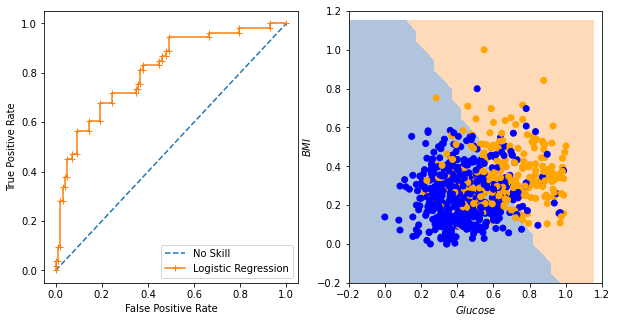

In [12]:
print('Logistic Regression')
modelLogReg = LogReg()
modelLogReg.fit(x_train, y_train)
y_pred_trainLogReg = modelLogReg.predict(x_train)
y_pred_testLogReg = modelLogReg.predict(x_test)
print('F1 score on training set: ',round(f1_score(y_train, y_pred_trainLogReg),4), '\nF1 score on test set: ',round(f1_score(y_test, y_pred_testLogReg), 4))


SKF = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
score = []
for train_index, test_index in SKF.split(x_test, y_test):
    x_test1 = x_train[test_index]
    y_test1 = y_train[test_index]
    score.append(f1_score(y_test1, modelLogReg.predict(x_test1)))
print('F1 score on 5-fold test data: ',round(np.mean(score),4),'+/-', round(np.std(score),4))

#ROC AUC and ROC curves
ns_probs = [0 for _ in range(len(y_test))]
# probabilities for the positive outcome
LogReg_probs = modelLogReg.predict_proba(x_test)[:, 1]
# calculate scores
ns_auc = roc_auc_score(y_test, ns_probs)
LogReg_auc = roc_auc_score(y_test, LogReg_probs)
# summarize scores
#print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('ROC AUC=%.3f' % (LogReg_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs, pos_label=None)
LogReg_fpr, LogReg_tpr, _ = roc_curve(y_test, LogReg_probs)

fig, (ax1, ax2) = plt.subplots(1,2, sharex=False, sharey=False, figsize=(10, 5))
# plot the roc curves
ax1.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
ax1.plot(LogReg_fpr,LogReg_tpr, marker='+', label='Logistic Regression')
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.legend()

#plot decision boundary   
plot_classifier_boundary(modelLogReg,x)
cmap = colors.ListedColormap(['blue','orange'])
ax2.scatter(x[:,0],x[:,1],color=cmap(y))
ax2.set_xlabel('$Glucose$')
ax2.set_ylabel('$BMI$')

plt.show();

Quadratic Discriminant Analysis
F1 score on training set:  0.6087 
F1 score on test set:  0.6154
F1 score on 5-fold test data:  0.515 +/- 0.1337
ROC AUC=0.807


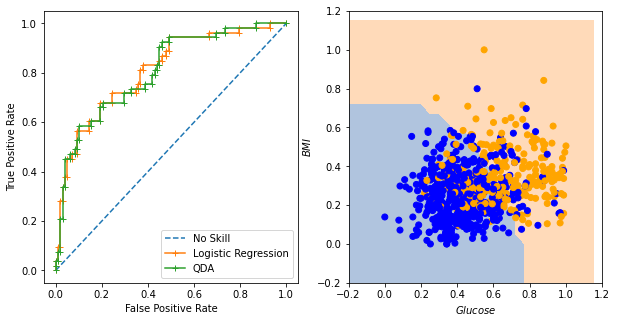

In [13]:
print('Quadratic Discriminant Analysis')
modelQDA = QDA()
modelQDA.fit(x_train, y_train)
y_pred_trainQDA = modelQDA.predict(x_train)
y_pred_testQDA = modelQDA.predict(x_test)
print('F1 score on training set: ',round(f1_score(y_train, y_pred_trainQDA),4), '\nF1 score on test set: ',round(f1_score(y_test, y_pred_testQDA), 4))

SKF = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
score_QDA = []
for train_index, test_index in SKF.split(x_test, y_test):
    x_test1 = x_train[test_index]
    y_test1 = y_train[test_index]
    score_QDA.append(f1_score(y_test1, modelQDA.predict(x_test1)))
print('F1 score on 5-fold test data: ',round(np.mean(score_QDA),4),'+/-', round(np.std(score_QDA),4))


#ROC AUC and ROC curves
ns_probs = [0 for _ in range(len(y_test))]
# probabilities for the positive outcome
QDA_probs = modelQDA.predict_proba(x_test)[:, 1]
# calculate scores
ns_auc = roc_auc_score(y_test, ns_probs)
QDA_auc = roc_auc_score(y_test, QDA_probs)
# summarize scores
#print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('ROC AUC=%.3f' % (QDA_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs, pos_label=None)
QDA_fpr, QDA_tpr, _ = roc_curve(y_test, QDA_probs)

fig, (ax1, ax2) = plt.subplots(1,2, sharex=False, sharey=False, figsize=(10, 5))
# plot the roc curves
ax1.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
ax1.plot(LogReg_fpr,LogReg_tpr, marker='+', label='Logistic Regression')
ax1.plot(QDA_fpr,QDA_tpr, marker='+', label='QDA')
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.legend()

#plot decision boundary   
plot_classifier_boundary(modelQDA,x)
cmap = colors.ListedColormap(['blue','orange'])
ax2.scatter(x[:,0],x[:,1],color=cmap(y))
ax2.set_xlabel('$Glucose$')
ax2.set_ylabel('$BMI$')

plt.show();

In [ ]:
kNN_acc_train = []
kNN_acc_val = []
kNN_acc_train_1 = []
kNN_acc_val_1 = []
for i in range(1,101):
    for train_index, val_index in SKF.split(x_train, y_train):
        x_train1, x_val1 = x_train[train_index], x_train[val_index]
        y_train1, y_val1 = y_train[train_index], y_train[val_index]
        modelkNN = kNN(n_neighbors=i).fit(x_train1, y_train1)
        y_pred_train=modelkNN.predict(x_train1)
        y_pred_val=modelkNN.predict(x_val1)
        kNN_acc_train.append(round(accuracy_score(y_train1, y_pred_train), 3))
        kNN_acc_val.append(round(accuracy_score(y_val1, y_pred_val), 3))
    kNN_acc_train_1.append(np.mean([kNN_acc_train]))
    kNN_acc_val_1.append(np.mean(kNN_acc_val))
    kNN_acc_train = []
    kNN_acc_val = []
    
data = {'k':  [*range(1,101)]*2, 'Accuracy': kNN_acc_train_1+kNN_acc_val_1, 'data': ['train']*100+['val']*100}
dataframes = pd.DataFrame(data, columns = ['k','Accuracy','data'])
sns.lineplot(data=dataframes, x="k", y="Accuracy", hue = 'data', markers=True, dashes=False);

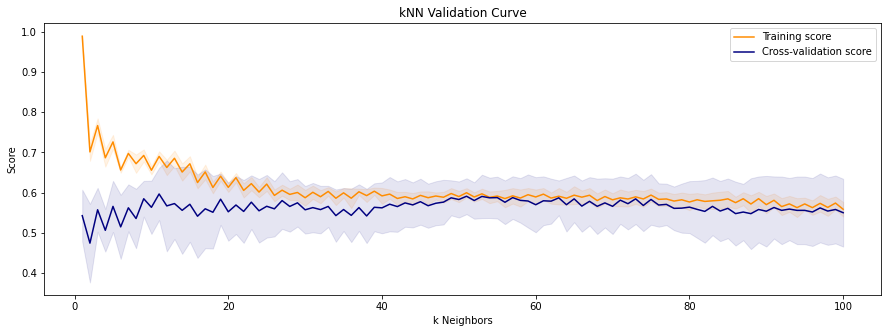

In [14]:
#Determination of k
modelkNN = kNN()
param_range = [*range(1,101)]
train_scores, test_scores = validation_curve(modelkNN, x_train, y_train, param_name="n_neighbors", param_range=param_range, scoring="f1", n_jobs=3)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure(figsize=(15, 5))
plt.title("kNN Validation Curve")
plt.xlabel("k Neighbors")
plt.ylabel("Score")
plt.plot(param_range, train_scores_mean, label="Training score", color="darkorange")
plt.fill_between(param_range, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="darkorange")
plt.plot(param_range, test_scores_mean, label="Cross-validation score", color="navy")
plt.fill_between(param_range, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="navy")
plt.legend(loc="best")
plt.show()

50 Nearest Neighbours
F1 score on training set:  0.5722 
F1 score on test set:  0.6154
F1 score on 5-fold test data:  0.4787 +/- 0.1339
ROC AUC=0.823


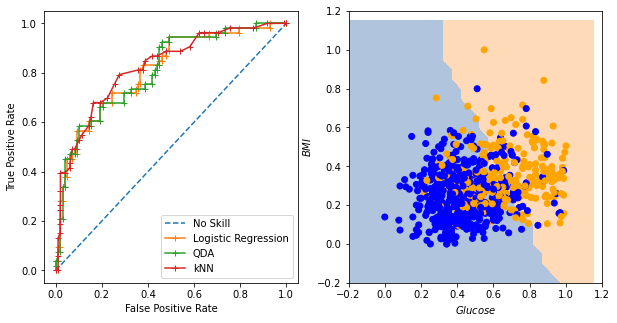

In [15]:
print('50 Nearest Neighbours')

modelkNN = kNN(n_neighbors=50)
modelkNN.fit(x_train, y_train)
y_pred_train_kNN = modelkNN.predict(x_train)
y_pred_test_kNN = modelkNN.predict(x_test)
print('F1 score on training set: ',round(f1_score(y_train, y_pred_train_kNN),4), '\nF1 score on test set: ',round(f1_score(y_test, y_pred_test_kNN), 4))

SKF = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
score_kNN = []
for train_index, test_index in SKF.split(x_test, y_test):
    x_test1 = x_train[test_index]
    y_test1 = y_train[test_index]
    score_kNN.append(f1_score(y_test1, modelkNN.predict(x_test1)))
print('F1 score on 5-fold test data: ',round(np.mean(score_kNN),4),'+/-', round(np.std(score_kNN),4))

#ROC AUC and ROC curves
ns_probs = [0 for _ in range(len(y_test))]
# probabilities for the positive outcome
kNN_probs = modelkNN.predict_proba(x_test)[:, 1]
# calculate scores
ns_auc = roc_auc_score(y_test, ns_probs)
kNN_auc = roc_auc_score(y_test, kNN_probs)
# summarize scores
#print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('ROC AUC=%.3f' % (kNN_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs, pos_label=None)
kNN_fpr, kNN_tpr, _ = roc_curve(y_test, kNN_probs)

fig, (ax1, ax2) = plt.subplots(1,2, sharex=False, sharey=False, figsize=(10, 5))
# plot the roc curves
ax1.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
ax1.plot(LogReg_fpr,LogReg_tpr, marker='+', label='Logistic Regression')
ax1.plot(QDA_fpr,QDA_tpr, marker='+', label='QDA')
ax1.plot(kNN_fpr,kNN_tpr, marker='+', label='kNN')
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.legend()

#plot decision boundary   
plot_classifier_boundary(modelkNN,x)
cmap = colors.ListedColormap(['blue','orange'])
ax2.scatter(x[:,0],x[:,1],color=cmap(y))
ax2.set_xlabel('$Glucose$')
ax2.set_ylabel('$BMI$')

plt.show();

## Section 2 - Model selection

##### Import data

In [19]:
yeast = pd.read_csv("yeast.data", header=None, sep = '\s+')
yeast.columns = ['Sequence Name', 'mcg', 'gvh', 'alm', 'mit', 'erl', 'pox', 'vac', 'nuc', 'Class']

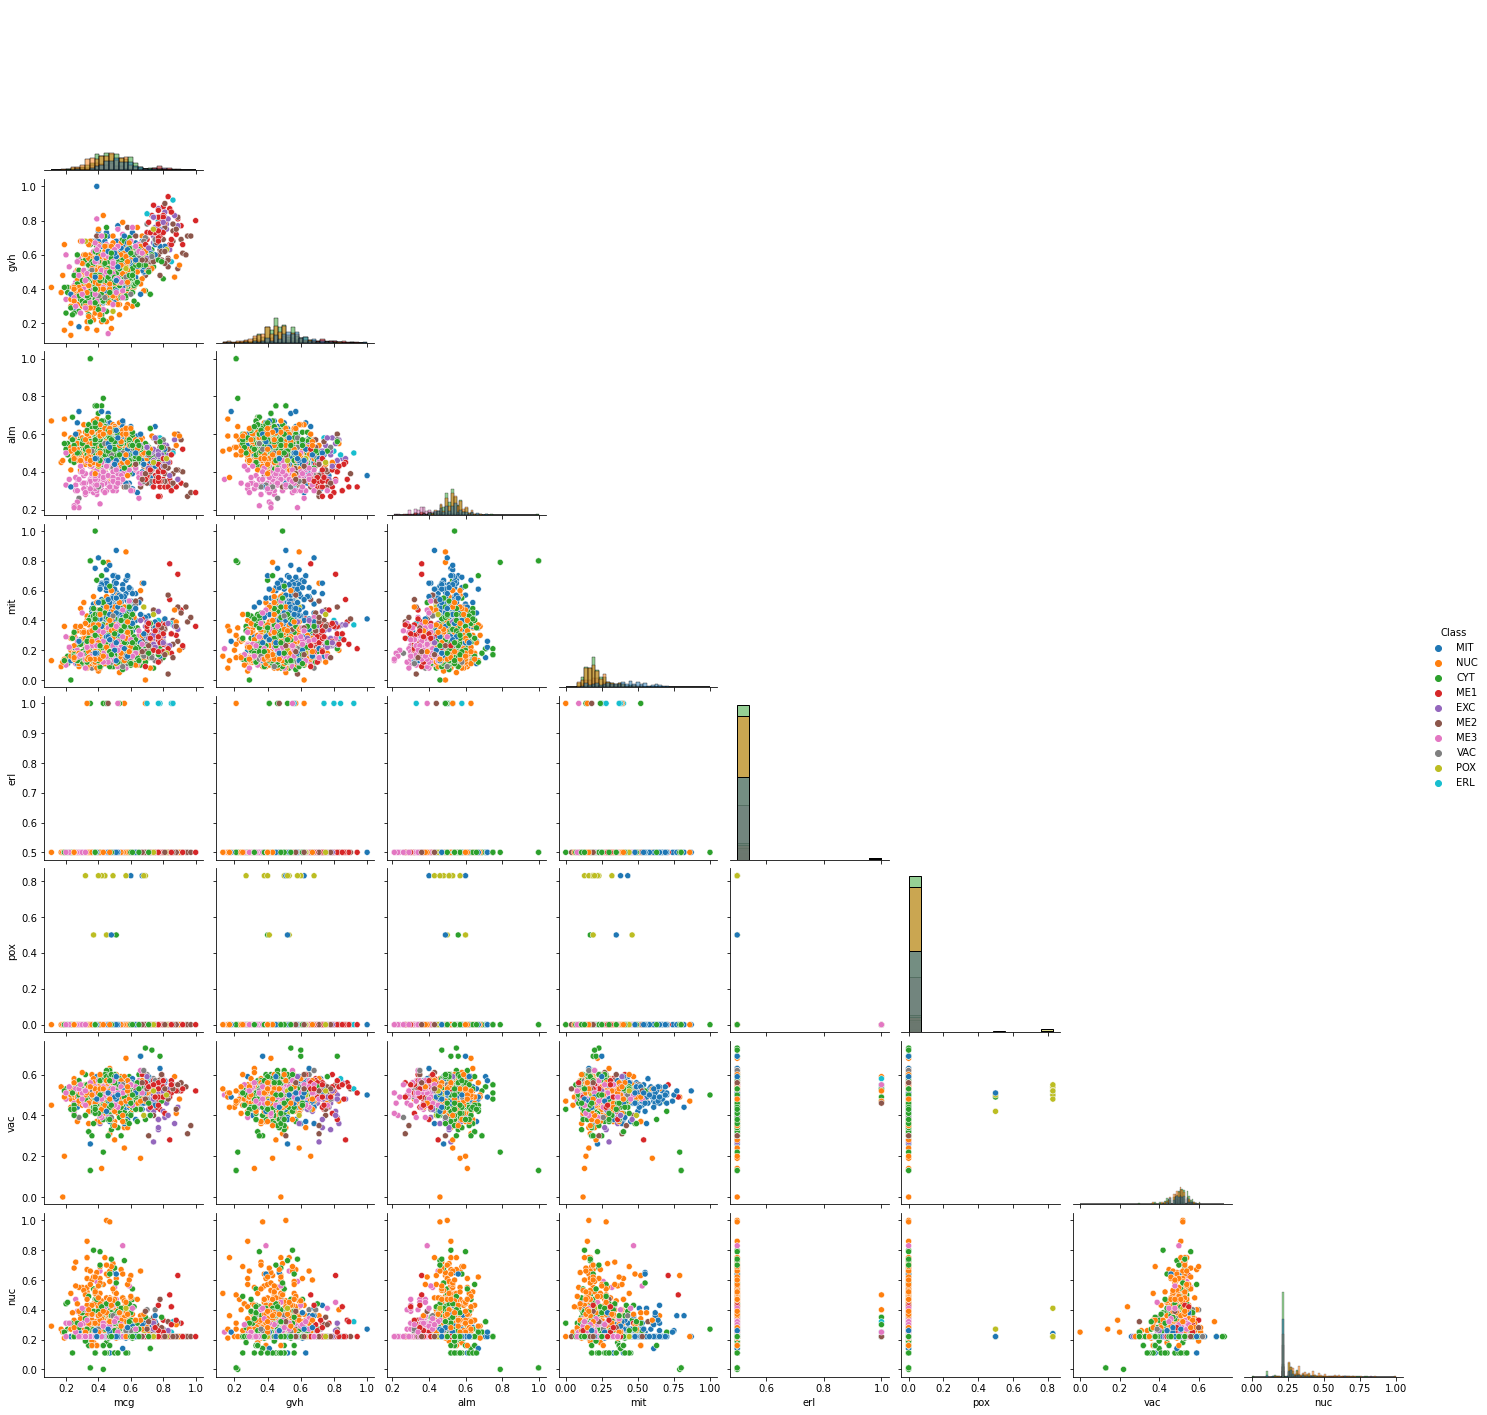

In [20]:
sns.pairplot(yeast, hue='Class', diag_kind="hist", corner=True);

##### Normalization

In [21]:
MinMaxSca = MinMaxScaler()
yeast[['mcg', 'gvh', 'alm', 'mit', 'erl', 'pox', 'vac', 'nuc']] = MinMaxSca.fit_transform(yeast.loc[:,['mcg', 'gvh', 'alm', 'mit', 'erl', 'pox', 'vac', 'nuc']])

##### Separation of variables and conversion to array

In [22]:
X = yeast.loc[:, ['mcg', 'gvh', 'alm', 'mit', 'erl', 'pox', 'vac', 'nuc']].values
Y = yeast.loc[:,'Class'].values

##### Separation of Train and Test data
Data was initially separed in two parts, a train subdataset that correspond to 80% of the initial data while the remaining 20% of the data were kept for model testing.


In [23]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 1, stratify = Y, shuffle=True)

In [24]:
SKF = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

### Logistic Regression

In [31]:
#Logistic Regression
print('Logistic Regression')
modelLR = LogReg(max_iter=1000)
modelLR.fit(X_train, Y_train)
Y_pred_trainLogReg = modelLR.predict(X_train)
Y_pred_testLogReg = modelLR.predict(X_test)
print('Weighted F1 score on training set: ',round(f1_score(Y_train, Y_pred_trainLogReg, average='weighted'),4), 
      '\nWeighted F1 score on test set: ',round(f1_score(Y_test, Y_pred_testLogReg, average='weighted'), 4))

f1score_LogReg = []
for train_index, test_index in SKF.split (X_test, Y_test):
    X_test1 = X_test[test_index]
    Y_test1 = Y_test[test_index]
    f1score_LogReg.append(f1_score(Y_test1, modelLR.predict(X_test1), average='weighted'))
print('Weighted F1 score on 5-fold test data: ',round(np.mean(f1score_LogReg),4),'+/-', round(np.std(f1score_LogReg),4))
print('\nClassification report:\n',classification_report(Y_test, Y_pred_testLogReg, digits=3))

Logistic Regression
Weighted F1 score on training set:  0.5564 
Weighted F1 score on test set:  0.5406
Weighted F1 score on 5-fold test data:  0.5383 +/- 0.0319

Classification report:
               precision    recall  f1-score   support

         CYT      0.504     0.742     0.600        93
         ERL      0.000     0.000     0.000         1
         EXC      0.000     0.000     0.000         7
         ME1      0.455     0.556     0.500         9
         ME2      0.000     0.000     0.000        10
         ME3      0.667     0.688     0.677        32
         MIT      0.617     0.592     0.604        49
         NUC      0.631     0.477     0.543        86
         POX      0.667     0.500     0.571         4
         VAC      0.000     0.000     0.000         6

    accuracy                          0.566       297
   macro avg      0.354     0.355     0.350       297
weighted avg      0.537     0.566     0.541       297



C:\Users\raque\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\raque\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\raque\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\raque\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score a

#### k Nearest Neighbours

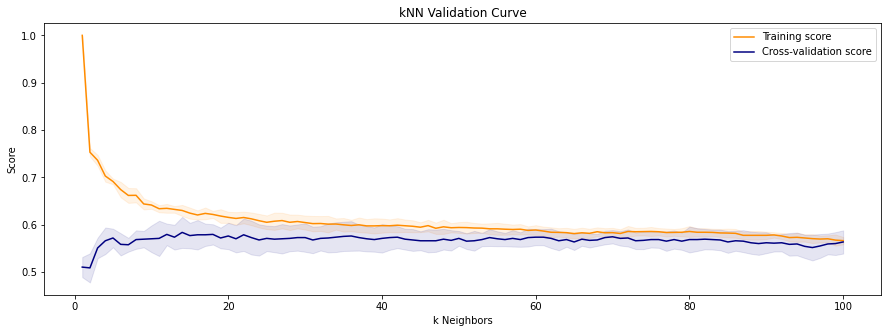

In [27]:
#Determination of k
modelknn = kNN()
param_range = [*range(1,101)]
train_scores, test_scores = validation_curve(modelknn, X_train, Y_train, param_name="n_neighbors", param_range=param_range, cv = 4, scoring="accuracy", n_jobs=3)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure(figsize=(15, 5))
plt.title("kNN Validation Curve")
plt.xlabel("k Neighbors")
plt.ylabel("Score")
plt.plot(param_range, train_scores_mean, label="Training score", color="darkorange")
plt.fill_between(param_range, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="darkorange")
plt.plot(param_range, test_scores_mean, label="Cross-validation score", color="navy")
plt.fill_between(param_range, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="navy")
plt.legend(loc="best")
plt.show()

In [ ]:
#kNN
fold_loss_train = []
fold_loss_val = []
fold_loss_train_1 = []
fold_loss_val_1 = []
for i in range(1,101):
    for train_index, val_index in SKF.split(X_train, Y_train):
        X_train1, X_val1 = X_train[train_index], X_train[val_index]
        Y_train1, Y_val1 = Y_train[train_index], Y_train[val_index]
        model_knn=kNN(i).fit(X_train1,Y_train1)
        Y_pred_train=model_knn.predict(X_train1)
        Y_pred_val=model_knn.predict(X_val1)
        fold_loss_train.append(round(f1_score(Y_train1, Y_pred_train, average='weighted'), 3))
        fold_loss_val.append(round(f1_score(Y_val1, Y_pred_val, average='weighted'), 3))
        #print(fold_loss_train,'\t',fold_loss_val)   
    #fold_loss_train_1 += [fold_loss_train]
    #fold_loss_val_1 += [fold_loss_val]
    fold_loss_train_1.append(np.mean([fold_loss_train]))
    fold_loss_val_1.append(np.mean(fold_loss_val))
    fold_loss_train = []
    fold_loss_val = []
    #print('\n')
#print(fold_loss_train_1, fold_loss_val_1)

In [ ]:
error_data = {'k':  [*range(1,101)]*2, 'weighted F1 score': fold_loss_train_1+fold_loss_val_1, 'data': ['train']*100+['val']*100}
error_dataframe = pd.DataFrame(error_data, columns = ['k','weighted F1 score','data'])
sns.lineplot(data=error_dataframe, x="k", y="weighted F1 score", hue = 'data', markers=True, dashes=False);

In [32]:
#kNN with k=40
#
print('k Nearest Neighbours')
modelknn = kNN(n_neighbors=40)
modelknn.fit(X_train, Y_train)
Y_pred_trainknn = modelknn.predict(X_train)
Y_pred_testknn = modelknn.predict(X_test)
print('Weighted F1 score on training set: ',round(f1_score(Y_train, Y_pred_trainLogReg, average='weighted'),4), 
      '\nWeighted F1 score on test set: ',round(f1_score(Y_test, Y_pred_testLogReg, average='weighted'), 4))

f1score_knn = []
for train_index, test_index in SKF.split (X_test, Y_test):
    X_test1 = X_test[test_index]
    Y_test1 = Y_test[test_index]
    f1score_knn.append(f1_score(Y_test1, modelknn.predict(X_test1), average='weighted'))
print('Weighted F1 score on 5-fold test data: ',round(np.mean(f1score_knn),4),'+/-', round(np.std(f1score_knn),4))
print('\nClassification report:\n',classification_report(Y_test, Y_pred_testknn, digits=3))

k Nearest Neighbours
Weighted F1 score on training set:  0.5564 
Weighted F1 score on test set:  0.5406
Weighted F1 score on 5-fold test data:  0.5443 +/- 0.0557

Classification report:
               precision    recall  f1-score   support

         CYT      0.516     0.688     0.590        93
         ERL      0.000     0.000     0.000         1
         EXC      0.500     0.571     0.533         7
         ME1      0.462     0.667     0.545         9
         ME2      0.000     0.000     0.000        10
         ME3      0.733     0.688     0.710        32
         MIT      0.688     0.673     0.680        49
         NUC      0.549     0.453     0.497        86
         POX      0.000     0.000     0.000         4
         VAC      0.000     0.000     0.000         6

    accuracy                          0.566       297
   macro avg      0.345     0.374     0.356       297
weighted avg      0.539     0.566     0.546       297



C:\Users\raque\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\raque\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\raque\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\raque\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score a

In [ ]:
#Grid search for decision tree best hyperparameters


In [33]:
#Decision Tree
print('Decision Tree')
modeltree = DTreeClass()
modeltree.fit(X_train, Y_train)
Y_pred_traintree = modeltree.predict(X_train)
Y_pred_testtree = modeltree.predict(X_test)
print('Weighted F1 score on training set: ',round(f1_score(Y_train, Y_pred_traintree, average='weighted'),4), 
      '\nWeighted F1 score on test set: ',round(f1_score(Y_test, Y_pred_testtree, average='weighted'), 4))

f1score_tree = []
for train_index, test_index in SKF.split (X_test, Y_test):
    X_test1 = X_test[test_index]
    Y_test1 = Y_test[test_index]
    f1score_tree.append(f1_score(Y_test1, modeltree.predict(X_test1), average='weighted'))
print('Weighted F1 score on 5-fold test data: ',round(np.mean(f1score_tree),4),'+/-', round(np.std(f1score_tree),4))
print('\nClassification report:\n',classification_report(Y_test, Y_pred_testtree, digits=3))


Decision Tree
Weighted F1 score on training set:  1.0 
Weighted F1 score on test set:  0.5001
Weighted F1 score on 5-fold test data:  0.4945 +/- 0.0288

Classification report:
               precision    recall  f1-score   support

         CYT      0.521     0.538     0.529        93
         ERL      0.000     0.000     0.000         1
         EXC      0.400     0.571     0.471         7
         ME1      0.600     0.667     0.632         9
         ME2      0.222     0.200     0.211        10
         ME3      0.719     0.719     0.719        32
         MIT      0.568     0.429     0.488        49
         NUC      0.462     0.500     0.480        86
         POX      0.000     0.000     0.000         4
         VAC      0.000     0.000     0.000         6

    accuracy                          0.502       297
   macro avg      0.349     0.362     0.353       297
weighted avg      0.503     0.502     0.500       297



C:\Users\raque\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\raque\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\raque\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\raque\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score a

In [ ]:
tree_auc = roc_auc_score(Y_test, model.predict_proba(X_test), multi_class='ovr', average='weighted')
print('Decision Tree: ROC AUC=%.3f' % (tree_auc))

## Conclusions